# Dataset Prep File

In [1]:
# LIBRARIES
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

from aif360.datasets import GermanDataset # <-- DATASET

from sklearn.metrics import accuracy_score,r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# ESTABLISH PARAMETERS
percent_test = 0.33
batch_size = 64
learning_rate = 0.01
epochs = 300

result_filepath = 'prepared_data/german.csv'

In [3]:
# GET DATA
# - pulling data from the aif360 library
# - using this library does require some setup

label_map = {0.0: 'Good Credit', 1.0: 'Bad Credit'}
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

data = GermanDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['male']],
    metadata={'label_map':label_map,'protected_attribute_maps': protected_attribute_maps})
data.labels = data.labels- 1

X = data.features
y = data.labels.ravel()

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (1000, 58)
Shape of y: (1000,)


In [4]:
# split into training and test
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size=percent_test)
n = X.shape[0]
test_n = int(n*percent_test)
test_i = random.sample(range(n),test_n)

X_test = np.take(X,test_i,axis=0)
X_train = np.delete(X,test_i,axis=0)

X_scaled_test = np.take(X_scaled,test_i,axis=0)
X_scaled_train = np.delete(X_scaled,test_i,axis=0)

y_test = np.take(y,test_i,axis=0)
y_train = np.delete(y,test_i,axis=0)

print("Train Size: {}".format(X_train.shape[0]))
print("Test Size:  {}".format(X_test.shape[0]))

Train Size: 670
Test Size:  330


## Modeling: Neural Net

In [5]:
class dataset(Dataset):
    
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        # self.fc1 = nn.Linear(input_shape,32)
        # self.fc2 = nn.Linear(32,64)
        # self.fc3 = nn.Linear(64,1)
        
        self.predict=nn.Linear(input_shape,1)
        
        # self.l1 = nn.Linear(input_shape,32)
        # self.l2 = nn.Linear(32,1)
    def forward(self,x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.sigmoid(self.fc3(x))
        
        x = torch.sigmoid(self.predict(x))
        
        # x = torch.relu(self.l1(x))
        # x = torch.sigmoid(self.l2(x))
        return x

In [6]:
# SETUP
trainset = dataset(X_scaled_train,y_train)
trainloader = DataLoader(trainset,batch_size=batch_size,shuffle=False)

model = Net(input_shape=X_scaled_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

epoch 0	loss : 0.6718420386314392	 accuracy : 0.5666666666666667
epoch 50	loss : 0.4271305799484253	 accuracy : 0.8333333333333334
epoch 100	loss : 0.3835795223712921	 accuracy : 0.9
epoch 150	loss : 0.36723771691322327	 accuracy : 0.9
epoch 200	loss : 0.3590816557407379	 accuracy : 0.9
epoch 250	loss : 0.35427823662757874	 accuracy : 0.9333333333333333


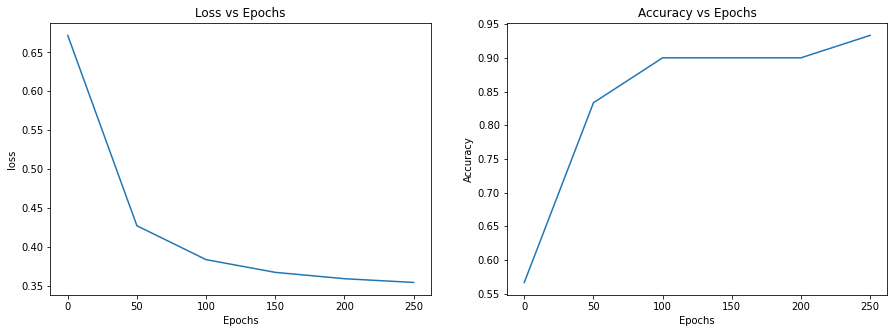

In [7]:
# TRAINING
epoch = []
losses = []
accur = []

for i in range(epochs):
    for j,(x_this,y_this) in enumerate(trainloader):

        #calculate output
        output = model(x_this)

        #calculate loss
        loss = loss_fn(output,y_this.reshape(-1,1))

        #accuracy
        # predicted = model(torch.tensor(x,dtype=torch.float32))
        # print(np.unique(predicted.reshape(-1).detach().numpy().round()))
        # print(np.unique(y))
        # print(np.unique(predicted.reshape(-1).detach().numpy().round() == y))
        # print(str(output[0])+','+str(y_train[0]))
        # print(
        acc = (output.reshape(-1).detach().numpy().round() == y_this.detach().numpy()).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        epoch.append(i)
        losses.append(loss.item())
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))
        

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epoch,losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epoch, accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [8]:
# GET OVERALL TEST RESULTS
x_tensor = torch.tensor(X_scaled_train,dtype=torch.float32)
y_pred = model(x_tensor)
y_train_pred = y_pred.detach().numpy()[:,0]

print('TRAIN Results')
accuracy = accuracy_score(y_train,y_train_pred.round())
r2 = r2_score(y_train,y_train_pred.round())
auc = roc_auc_score(y_train,y_train_pred.round())

print('Accuracy: '+str(accuracy))
print('R2:       '+str(r2))
print('AUC:      '+str(auc))

TRAIN Results
Accuracy: 0.7955223880597015
R2:       -0.00015254532775443863
AUC:      0.7180199616457462


In [9]:
x_tensor = torch.tensor(X_scaled_test,dtype=torch.float32)
y_pred = model(x_tensor)
y_test_pred = y_pred.detach().numpy()[:,0]


print('TEST Results')
accuracy = accuracy_score(y_test,y_test_pred.round())
r2 = r2_score(y_test,y_test_pred.round())
auc = roc_auc_score(y_test,y_test_pred.round())

print('Accuracy: '+str(accuracy))
print('R2:       '+str(r2))
print('AUC:      '+str(auc))

# pd.crosstab(df_test['y_true'],df_test['y_pred'], rownames=['Actual'], colnames=['Predicted'])

TEST Results
Accuracy: 0.7545454545454545
R2:       -0.11486486486486491
AUC:      0.6796796796796797


In [10]:
df = pd.DataFrame(X_test, columns=data.feature_names)
df['y_true'] = y_test
df['y_pred_score'] = y_test_pred
df['y_pred'] = y_test_pred.round()
df.to_csv(result_filepath,index=False) # save to csv

# show confusion matrix
pd.crosstab(df['y_true'],df['y_pred'], rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,199,23
1.0,58,50
